# Visualize Differences Across Cell Lines

**Gregory Way, 2019**

Visualize mean square error per feature for each cell line independently.

Also shown are F statistics, which calculates the ratio of between group variance / within group variance.

Therefore, we can interpret high F statistic values as cell health features with large differences in performance across cell lines while low values indicate features that are consistent across cell lines.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

source(file.path("scripts", "assay_themes.R"))

In [2]:
set.seed(123)

In [3]:
consensus <- "modz"
cell_lines <- c("A549", "ES2", "HCC44")

In [4]:
results_dir <- "results"
figure_dir <- file.path("figures", "cell_line_performance", consensus)

dir.create(figure_dir, recursive = TRUE, showWarnings = FALSE)

In [5]:
build_plot_data <- function(
    results_df, cell_line="A549", data_fit="test", metric="r_two", results_type="regression"
) {
    # Function to prepare data for plotting
    plot_df <- results_df %>%
        dplyr::filter(
            cell_line == !!cell_line,
            data_fit == !!data_fit,
            metric == !!metric
        )
    
    if (results_type == "regression") {
        plot_df <- plot_df  %>%
            dplyr::select(
                value, metric, shuffle, target, original_name, readable_name,
                feature_type, measurement, assay, description
            )
    } else {
        plot_df <- plot_df  %>%
            dplyr::select(
                auc, metric, shuffle, target, original_name, readable_name,
                feature_type, measurement, assay, description
            )
    }

    return(plot_df)
}

## Load Label Data

In [6]:
# Set label directory
label_dir <- file.path(
    "..",
    "1.generate-profiles",
    "data",
    "labels"
)

# Annotated Cell Health Features
feat_file <- file.path(label_dir, "feature_mapping_annotated.csv")
label_df <- readr::read_csv(feat_file, col_types = readr::cols())

# Normalized Readouts
readouts_file <- file.path(label_dir, "normalized_cell_health_labels.tsv")
readouts_df <- readr::read_tsv(readouts_file, col_types = readr::cols())

# Metadata mapping
mapping_file <- file.path("..", "1.generate-profiles", "data", "profile_id_metadata_mapping.tsv")
mapping_df <- readr::read_tsv(mapping_file, col_types = readr::cols())

# Model Predictions
y_file <- file.path(
    "results",
    paste0("full_cell_health_y_labels_", consensus, ".tsv.gz")
)
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform == "raw")

## Load Metrics Data

In [7]:
regression_file <- file.path(
    results_dir,
    paste0("full_cell_health_regression_", consensus, ".tsv.gz")
)
regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line %in% cell_lines)
    
head(regression_metrics_df)

value,metric,target,data_fit,shuffle,y_transform,cell_line
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.7436654,mse,cc_all_high_h2ax,train,shuffle_true,raw,HCC44
0.8820456,mse,cc_all_high_h2ax,test,shuffle_true,raw,HCC44
0.7200331,mse,cc_all_high_h2ax,train,shuffle_true,raw,A549
0.1615799,mse,cc_all_high_h2ax,test,shuffle_true,raw,A549
0.6431792,mse,cc_all_high_h2ax,train,shuffle_true,raw,ES2
1.0012829,mse,cc_all_high_h2ax,test,shuffle_true,raw,ES2


## Process independent sample squared error

In [8]:
all_model_error <- list()
for (target in unique(y_df$target)) {
    for (shuffle in c("shuffle_true", "shuffle_false")) {
        y_train <- y_df %>%
            dplyr::filter(target == !!target, data_type == "train", shuffle == !!shuffle) %>%
            dplyr::arrange(Metadata_profile_id) %>%
            tidyr::spread(key = "y_type", value = "recode_target_value") %>%
            dplyr::mutate(squared_diff = (y_pred - y_true) ** 2)

        y_test <- y_df %>%
            dplyr::filter(target == !!target, data_type == "test", shuffle == !!shuffle) %>%
            dplyr::arrange(Metadata_profile_id) %>%
            tidyr::spread(key = "y_type", value = "recode_target_value") %>%
            dplyr::mutate(squared_diff = (y_pred - y_true) ** 2)
        
        y_complete <- dplyr::bind_rows(y_train, y_test)
        all_model_error[[paste0(target, shuffle)]] <- y_complete
    }
}


In [9]:
all_model_error_df <- do.call(rbind, all_model_error)

crispr_efficiency_df <- all_model_error_df %>%
    dplyr::filter(target == "vb_infection_percentage") %>%
    dplyr::select(Metadata_profile_id, y_true) %>%
    dplyr::distinct() %>%
    dplyr::rename(crispr_efficiency = y_true)

all_model_error_df <- all_model_error_df %>%
    dplyr::left_join(crispr_efficiency_df, by="Metadata_profile_id") %>%
    dplyr::left_join(mapping_df, by = "Metadata_profile_id")

print(dim(all_model_error_df))
head(all_model_error_df)

[1] 49980    11


Metadata_profile_id,target,data_type,shuffle,y_transform,y_pred,y_true,squared_diff,crispr_efficiency,Metadata_cell_line,Metadata_pert_name
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
profile_0,cc_all_high_h2ax,train,shuffle_true,raw,0.2240161,-0.005795126,0.052813190,-0.048178070,A549,AKT1-1
profile_1,cc_all_high_h2ax,train,shuffle_true,raw,0.1437434,0.050169440,0.008756086,-0.303983949,A549,AKT1-2
profile_10,cc_all_high_h2ax,train,shuffle_true,raw,0.2853536,-0.182172368,0.218580552,-0.309601542,A549,BCL2-2
profile_100,cc_all_high_h2ax,train,shuffle_true,raw,0.3507496,0.064109947,0.082162313,0.008356892,A549,RAF1-2
profile_101,cc_all_high_h2ax,train,shuffle_true,raw,0.5948523,1.767355244,1.374763175,0.107437373,A549,RHOA-1
profile_104,cc_all_high_h2ax,train,shuffle_true,raw,0.2656089,0.030281469,0.055378979,-1.055309652,A549,SDHB-2


In [10]:
regression_summary_df <- regression_metrics_df %>%
    dplyr::filter(metric == "r_two") %>%
    dplyr::group_by(data_fit, shuffle, cell_line) %>%
    dplyr::mutate(
        mean_rsquared_diff = mean(value),
        high_r2err_conf = quantile(value, 0.95),
        low_r2err_conf = quantile(value, 0.05)
    ) %>%
    dplyr::select(data_fit, shuffle, cell_line, mean_rsquared_diff, high_r2err_conf, low_r2err_conf) %>%
    dplyr::distinct()

summary_df <- all_model_error_df %>%
    dplyr::group_by(data_type, shuffle, Metadata_cell_line) %>%
    dplyr::mutate(
        mean_crispr_eff = mean(crispr_efficiency),
        mean_squared_diff = mean(squared_diff),
        high_crispr_conf = quantile(crispr_efficiency, 0.95),
        low_crispr_conf = quantile(crispr_efficiency, 0.05),
        high_err_conf = quantile(squared_diff, 0.95),
        low_err_conf = quantile(squared_diff, 0.05)
    ) %>%
    dplyr::select(
        data_type, shuffle, Metadata_cell_line, mean_crispr_eff, mean_squared_diff,
        high_crispr_conf, low_crispr_conf, high_err_conf, low_err_conf
    ) %>%
    dplyr::ungroup() %>%
    dplyr::distinct() %>%
    dplyr::left_join(
        regression_summary_df,
        by = c("shuffle" = "shuffle", "Metadata_cell_line" = "cell_line", "data_type" = "data_fit")
    )

summary_df$shuffle <- dplyr::recode_factor(
    summary_df$shuffle,
    "shuffle_true" = "Permuted",
    "shuffle_false" = "Real"
)
summary_df$data_type <- dplyr::recode_factor(
    summary_df$data_type,
    "train" = "Training",
    "test" = "Test"
)

summary_df$shuffle <- factor(summary_df$shuffle, levels = c("Real", "Permuted"))
summary_df$data_type <- factor(summary_df$data_type, levels = c("Training", "Test"))


summary_df

data_type,shuffle,Metadata_cell_line,mean_crispr_eff,mean_squared_diff,high_crispr_conf,low_crispr_conf,high_err_conf,low_err_conf,mean_rsquared_diff,high_r2err_conf,low_r2err_conf
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Training,Permuted,A549,-0.007457263,0.4791514,0.5153508,-0.6268152,1.7157788,0.0008741640,-0.027753052,0.1352695,-0.23678568
Training,Permuted,ES2,0.055607937,0.5392594,0.5104983,-0.2954622,1.6717208,0.0009692665,-0.007456616,0.1787879,-0.19595911
Training,Permuted,HCC44,0.089243697,0.3689451,0.6896565,-0.5371247,1.3293953,0.0009985861,-0.055955857,0.1592291,-0.28935338
Test,Permuted,A549,-0.071928698,0.3925877,0.6908887,-0.9532425,1.4631368,0.0014247867,-0.298873995,0.1477381,-0.86172273
Test,Permuted,ES2,0.083461814,0.5438250,0.6070311,-0.2673879,2.3944258,0.0011380996,-0.080966741,0.3088839,-0.69844218
Test,Permuted,HCC44,0.083680003,0.5621383,0.5875817,-0.4396810,2.1623579,0.0016522951,-0.096882435,0.2272044,-0.48478668
Training,Real,A549,-0.007457263,0.3199412,0.5153508,-0.6268152,1.0403736,0.0005955991,0.414984672,0.8478186,-0.01995759
Training,Real,ES2,0.055607937,0.2245126,0.5104983,-0.2954622,0.7861050,0.0005072977,0.597961703,0.9560869,0.03878915
Training,Real,HCC44,0.089243697,0.2258837,0.6896565,-0.5371247,0.8274414,0.0007132788,0.467087503,0.7770369,-0.00654614


## Observe CRISPR Efficiency Relationship with Performance

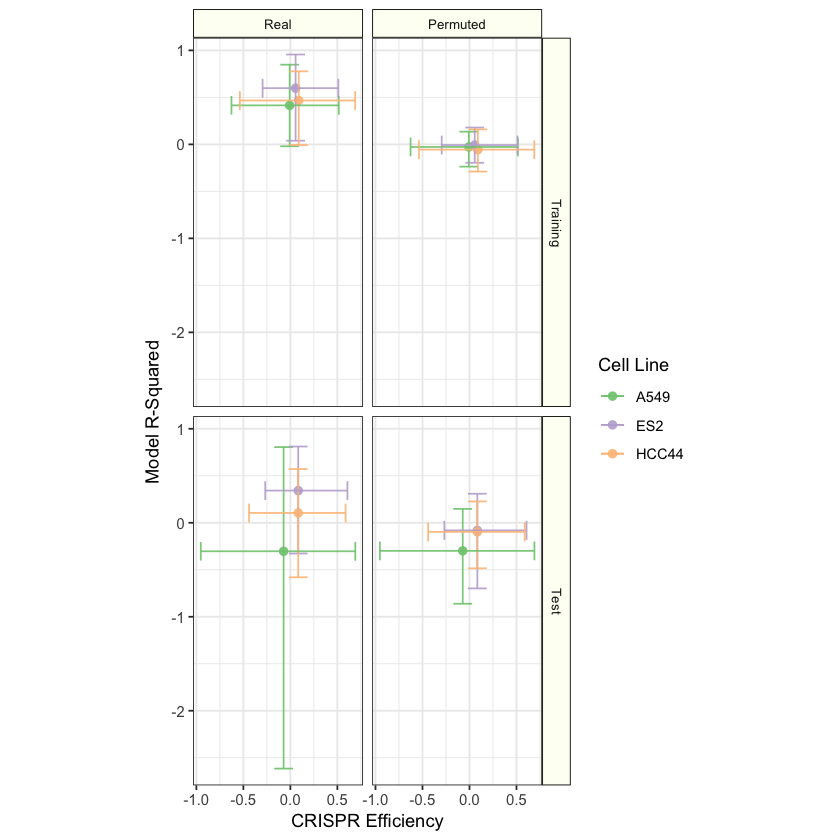

In [11]:
ggplot(summary_df, aes(x = mean_crispr_eff, y = mean_rsquared_diff, color = Metadata_cell_line)) +
    geom_point(size = 2, alpha = 0.9) +
    geom_errorbar(aes(ymin = low_r2err_conf, ymax = high_r2err_conf), alpha = 0.9, width = 0.2) +
    geom_errorbarh(aes(xmin = low_crispr_conf, xmax = high_crispr_conf), alpha = 0.9, height = 0.2) +
    facet_grid(data_type~shuffle) +
    ylab("Model R-Squared") +
    xlab("CRISPR Efficiency") + 
    scale_color_manual(
        name = "Cell Line",
        labels = cell_line_labels,
        values = cell_line_colors
    ) +
    coord_fixed() +
    theme_bw() +
    theme(axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("crispr_efficiency_regression_compare_", consensus, ".png")
)
ggsave(output_file, height = 4.5, width = 4.5, dpi = 500)

## Visualize

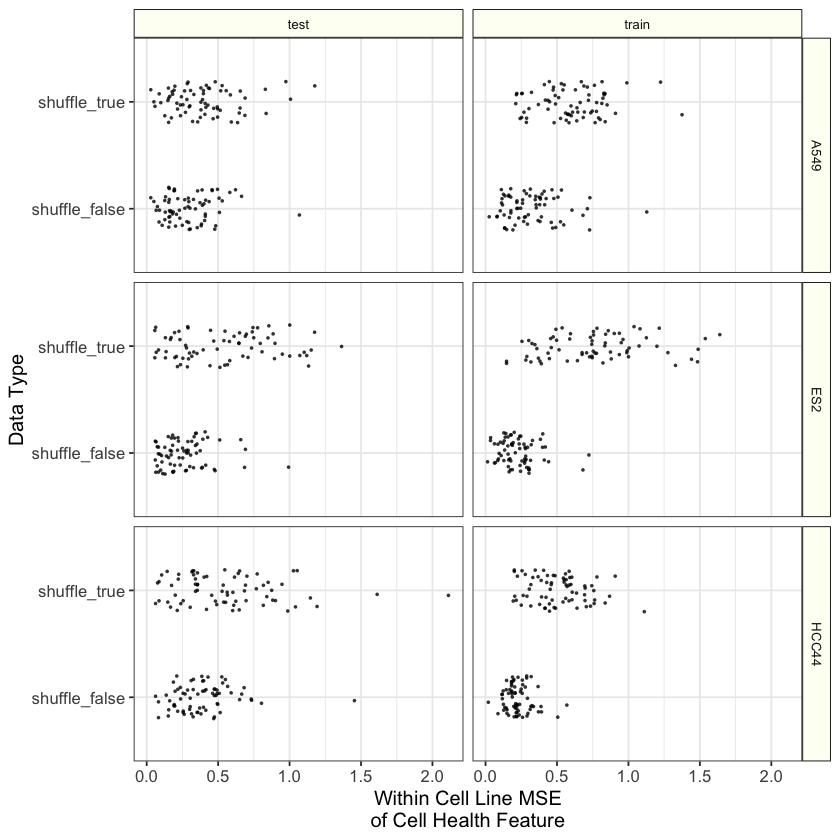

In [12]:
ggplot(regression_metrics_df %>% dplyr::filter(metric == "mse"),
       aes(x = shuffle,
           y = value)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_grid(cell_line~data_fit) +
    xlab("Data Type") +
    ylab("Within Cell Line MSE\nof Cell Health Feature") +
    coord_flip() +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_mse_differences_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 5, dpi = 500)

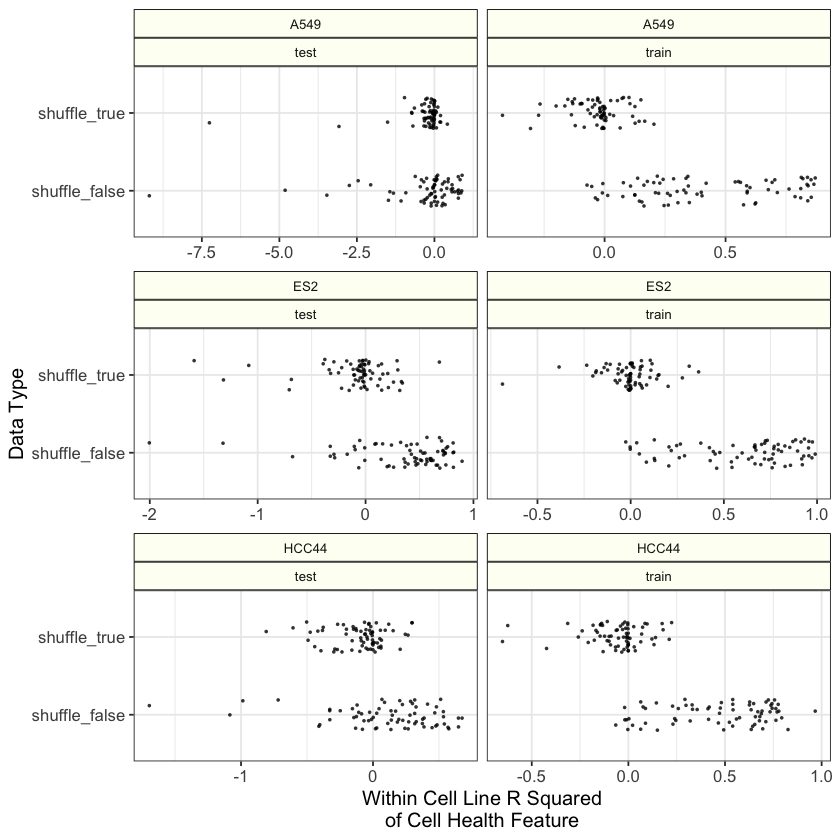

In [13]:
ggplot(regression_metrics_df %>% dplyr::filter(metric == "r_two"),
       aes(x = shuffle,
           y = value)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_wrap(cell_line~data_fit, ncol = 2, scales = "free_x") +
    xlab("Data Type") +
    ylab("Within Cell Line R Squared\nof Cell Health Feature") +
    coord_flip() +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_rsquared_differences_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 5, dpi = 500)

In [14]:
# Compile Results
regression_results_df <- regression_metrics_df %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::mutate(plot_group = paste(metric, target, shuffle))

dim(regression_results_df)
head(regression_results_df, 2)

[1] 1680   23

value,metric,target,data_fit,shuffle,y_transform,cell_line,readable_name,original_name,feature_type,⋯,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,plot_group
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
0.7436654,mse,cc_all_high_h2ax,train,shuffle_true,raw,HCC44,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,⋯,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,mse cc_all_high_h2ax shuffle_true
0.8820456,mse,cc_all_high_h2ax,test,shuffle_true,raw,HCC44,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,⋯,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,mse cc_all_high_h2ax shuffle_true


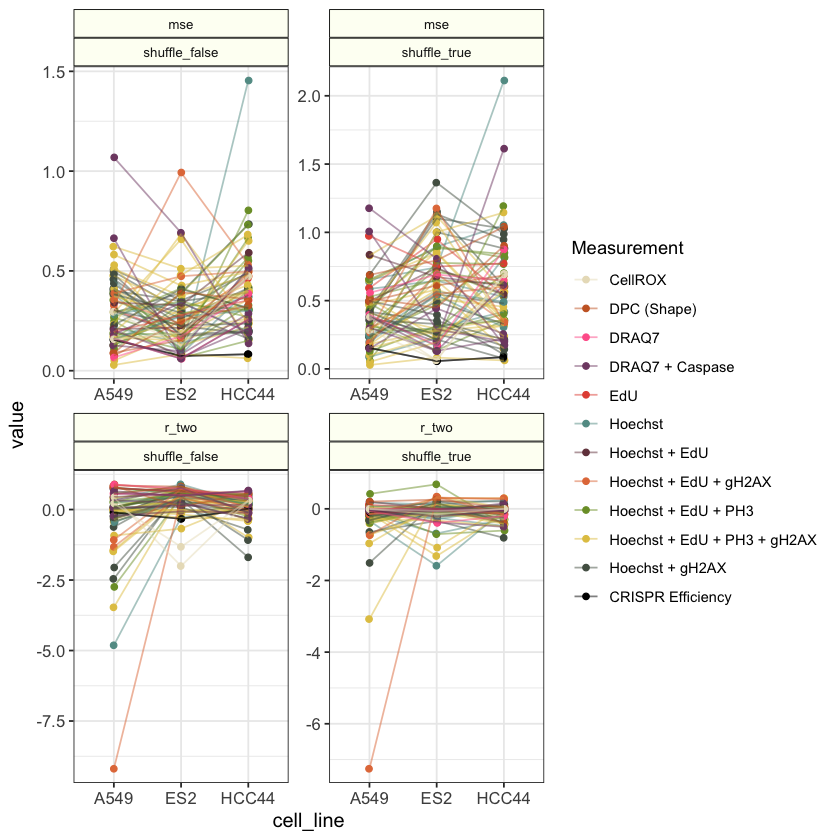

In [15]:
ggplot(regression_results_df %>%
       dplyr::filter(data_fit == "test"),
       aes(x = cell_line,
           y = value,
           group = plot_group)) +
    geom_jitter(aes(color = assay), width = 0.01) +
    geom_line(aes(color = assay),
              alpha = 0.5) +
    scale_color_manual(name = "Measurement",
                       values = dye_colors,
                       labels = dye_labels) +
    facet_wrap(metric~shuffle, scales = "free") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_differences_target_linked_full_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 6.5, dpi = 500)

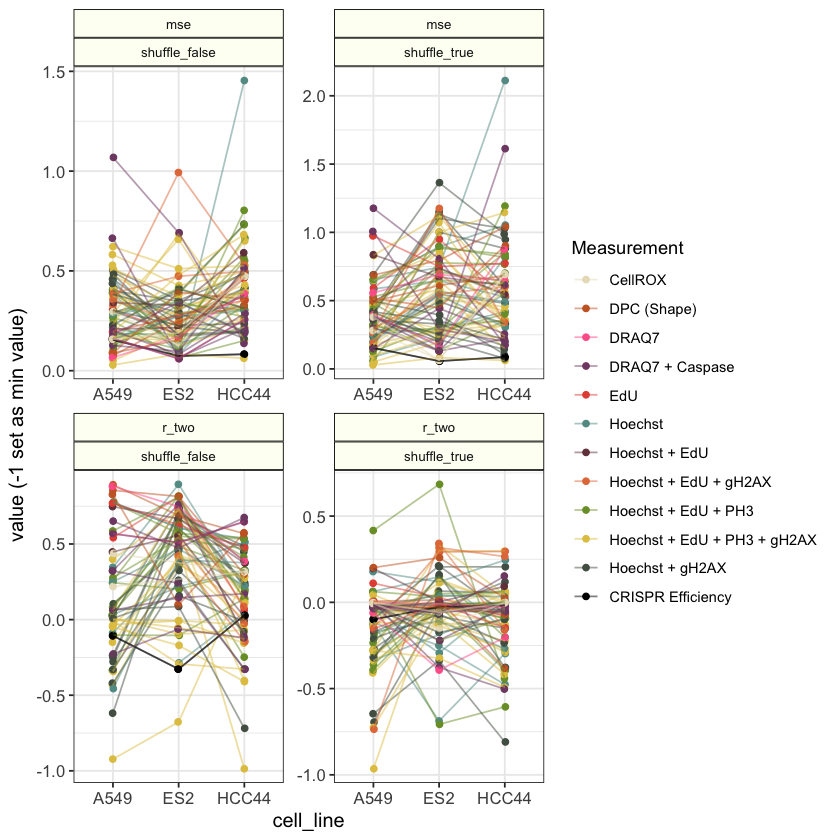

In [16]:
ggplot(regression_results_df %>%
       dplyr::filter(data_fit == "test",
                     value > -1),
       aes(x = cell_line,
           y = value,
           group = plot_group)) +
    geom_jitter(aes(color = assay), width = 0.01) +
    geom_line(aes(color = assay),
              alpha = 0.5) +
    ylab("value (-1 set as min value)") +
    scale_color_manual(name = "Measurement",
                       values = dye_colors,
                       labels = dye_labels) +
    facet_wrap(metric~shuffle, scales = "free") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_differences_target_linked_subset_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 6.5, dpi = 500)

## Rank Models

Laslty, we rank models based on test set regression peformance in A549 cells.

In [17]:
spread_regression_results_df <- regression_results_df %>%
    dplyr::filter(
        cell_line == "A549",
        data_fit == "test",
        metric == "r_two"
    ) %>%
    dplyr::select(
        value, metric, shuffle, target, original_name, readable_name,
        feature_type, measurement, assay, description
    ) %>%
    tidyr::spread(shuffle, value) %>%
    dplyr::arrange(desc(shuffle_false))

spread_regression_results_df$target <- factor(
    spread_regression_results_df$target,
    levels = rev(unique(spread_regression_results_df$target))
)
spread_regression_results_df$original_name <- factor(
    spread_regression_results_df$original_name,
    levels = rev(unique(spread_regression_results_df$original_name))
)

# Output ranked models
output_file <- file.path(
    "..",
    "4.apply",
    "repurposing_cellhealth_shiny",
    "data",
    paste0("A549_ranked_models_regression_", consensus, ".tsv")
)
readr::write_tsv(spread_regression_results_df, output_file)

print(dim(spread_regression_results_df))
head(spread_regression_results_df, 10)

[1] 70 10


metric,target,original_name,readable_name,feature_type,measurement,assay,description,shuffle_false,shuffle_true
<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
r_two,vb_live_cell_width_length,Live Width:Length,Live Width / Length,viability,shape,dpc,Width/Length,0.8916483,6.635413e-03
r_two,vb_num_live_cells,# Live Cells,# Live Cells,viability,death,draq,Number of live cells,0.8811216,-5.934792e-06
r_two,vb_live_cell_roundness,Live Cell Roundness,Live Cell Roundness,viability,shape,dpc,Cell Roundness,0.8552069,2.012126e-01
r_two,vb_live_cell_area,Live Cell Area [um2],Live Cell Area,viability,shape,dpc,Cell Size,0.8274196,-3.280656e-02
r_two,cc_cc_n_objects,CC - Number of Objects,CC - # cells,cell_cycle,cell_viability,hoechst,Number of cells selected for cell cycle,0.7778243,1.781785e-01
r_two,cc_g1_n_objects,G1 - Number of Objects,G1 - # cells,cell_cycle,g1_phase,hoechst_edu_ph3,Number of G1 cells,0.7742467,6.178493e-02
r_two,cc_all_n_objects,ALL - Number of Objects,ALL - # cells,cell_cycle,cell_viability,hoechst,Total number of cells,0.7714360,-1.176881e-01
r_two,cc_s_n_objects,edu positive - Number of Objects,S - # cells,cell_cycle,s_phase,edu,Number of S-phase cells,0.7692960,-1.548429e-01
r_two,cc_s_intensity_nucleus_area_sum,edu positive - Intensity Nucleus Alexa 647 Sum - Sum per Well,S - Intensity Nucleus EdU Sum,cell_cycle,s_phase,hoechst_edu,In S phase cells: how much EdU was incorporated (average total signal per cell),0.7470967,-1.287059e-02


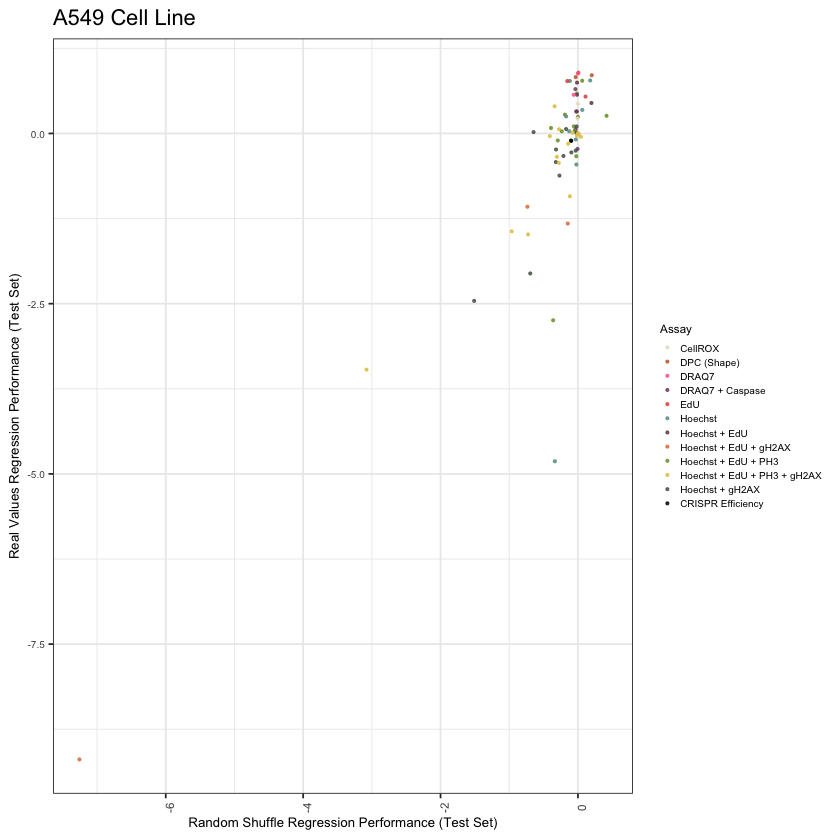

In [18]:
ggplot(spread_regression_results_df, aes(x = shuffle_true, y = shuffle_false)) +
    geom_point(aes(color = assay),
               size = 0.5,
               alpha = 0.8) +
    xlab("Random Shuffle Regression Performance (Test Set)") +
    ylab("Real Values Regression Performance (Test Set)") +
    ggtitle("A549 Cell Line") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 6),
          axis.text.x = element_text(size = 7, angle = 90),
          axis.title = element_text(size = 8),
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 6),
          legend.key.size = unit(0.3, "cm")) +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) 

output_file = file.path(
    figure_dir,
    paste0("ranked_models_A549_with_shuffle_", consensus, ".png")
)
ggsave(output_file, dpi = 300, height = 3.5, width = 4)

In [19]:
regression_rank_plot_df <- build_plot_data(
    regression_results_df, cell_line="A549", data_fit="test", metric="r_two"
)

sorted_non_shuffle <- regression_rank_plot_df %>%
    dplyr::filter(shuffle == "shuffle_false") %>%
    dplyr::arrange(desc(value))

target_levels <- rev(
    sorted_non_shuffle %>%
        dplyr::pull(target)
    )

name_levels <- rev(
    sorted_non_shuffle %>%
        dplyr::pull(readable_name)
    )

regression_rank_plot_df$target <- factor(
    regression_rank_plot_df$target, levels = target_levels
)
regression_rank_plot_df$readable_name <- factor(
    regression_rank_plot_df$readable_name,
    levels = name_levels
)

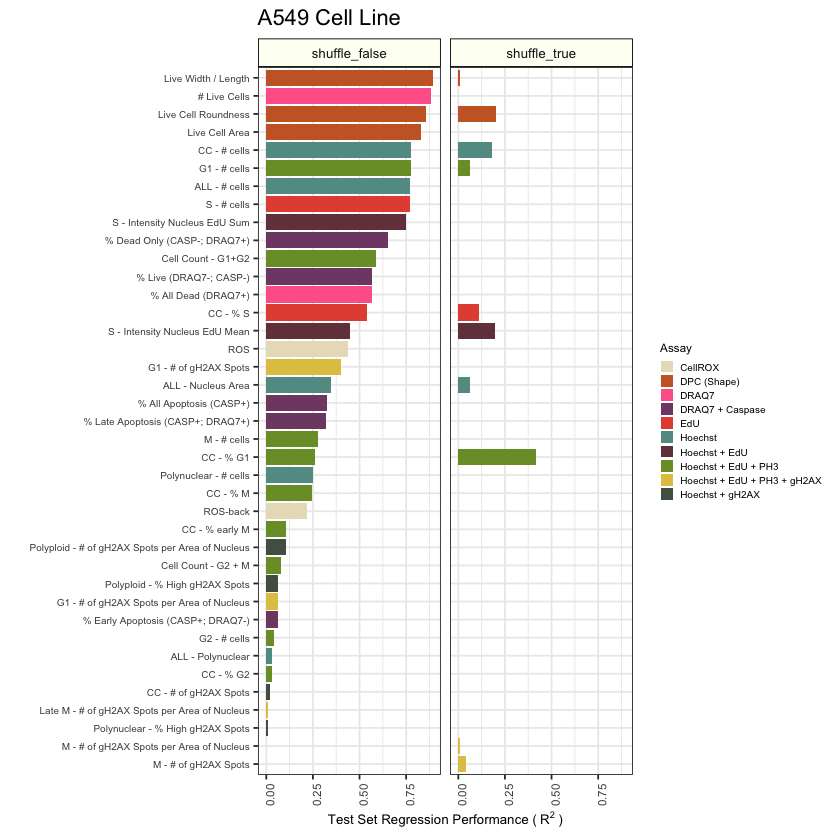

In [20]:
ggplot(regression_rank_plot_df %>%
           dplyr::filter(value > 0),
       aes(x = readable_name, y = value)) +
    geom_bar(aes(fill = assay), stat="identity") +
    ylab(bquote("Test Set Regression Performance ("~R^2~")")) +
    xlab("") +
    ggtitle("A549 Cell Line") +
    coord_flip() +
    theme_bw() +
    facet_wrap(~shuffle, nrow = 1) +
    theme(
        axis.text.y = element_text(size = 6),
        axis.text.x = element_text(size = 7, angle = 90),
        axis.title = element_text(size = 8),
        legend.title = element_text(size = 7),
        strip.text = element_text(size = 8),
        strip.background = element_rect(colour = "black",
                                      fill = "#fdfff4"),
        legend.text = element_text(size = 6),
        legend.key.size = unit(0.3, "cm")
    ) +
    scale_fill_manual(
        name = "Assay",
        values = dye_colors,
        labels = dye_labels
    ) 

output_file = file.path(
    figure_dir,
    paste0("ranked_models_A549_", consensus, ".png")
)
ggsave(output_file, dpi = 300, height = 6, width = 8)

## Determine Classification Performance

In [21]:
roc_file <- file.path(
    results_dir,
    paste0("full_cell_health_roc_results_", consensus, ".tsv.gz")
)
full_roc_df <- readr::read_tsv(roc_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line %in% cell_lines)

pr_file <- file.path(results_dir,
                     paste0("full_cell_health_pr_results_", consensus, ".tsv.gz"))
full_pr_df <- readr::read_tsv(pr_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line %in% cell_lines)

auroc_df <- full_roc_df %>%
    dplyr::distinct(metric, target, auc, cell_line, data_fit, shuffle, y_transform, min_class_count)

aupr_df <- full_pr_df %>%
    dplyr::distinct(metric, target, auc, cell_line, data_fit, shuffle, y_transform, min_class_count)

auc_df <- dplyr::bind_rows(auroc_df, aupr_df)

# Replace missing data with zero (for plotting reasons)
auc_df$auc[is.na(auc_df$auc)] <- 0

head(auc_df, 10)

metric,target,auc,cell_line,data_fit,shuffle,y_transform,min_class_count
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
roc,cc_all_high_h2ax,0.40917603,HCC44,train,shuffle_true,binarize,29
roc,cc_all_high_h2ax,0.07142857,HCC44,test,shuffle_true,binarize,29
roc,cc_all_high_h2ax,0.25934066,A549,train,shuffle_true,binarize,29
roc,cc_all_high_h2ax,0.00000000,A549,test,shuffle_true,binarize,29
roc,cc_all_high_h2ax,0.08510638,ES2,train,shuffle_true,binarize,29
roc,cc_all_high_h2ax,0.25000000,ES2,test,shuffle_true,binarize,29
roc,cc_all_high_h2ax,0.92228464,HCC44,train,shuffle_false,binarize,29
roc,cc_all_high_h2ax,0.44642857,HCC44,test,shuffle_false,binarize,29
roc,cc_all_high_h2ax,0.89450549,A549,train,shuffle_false,binarize,29


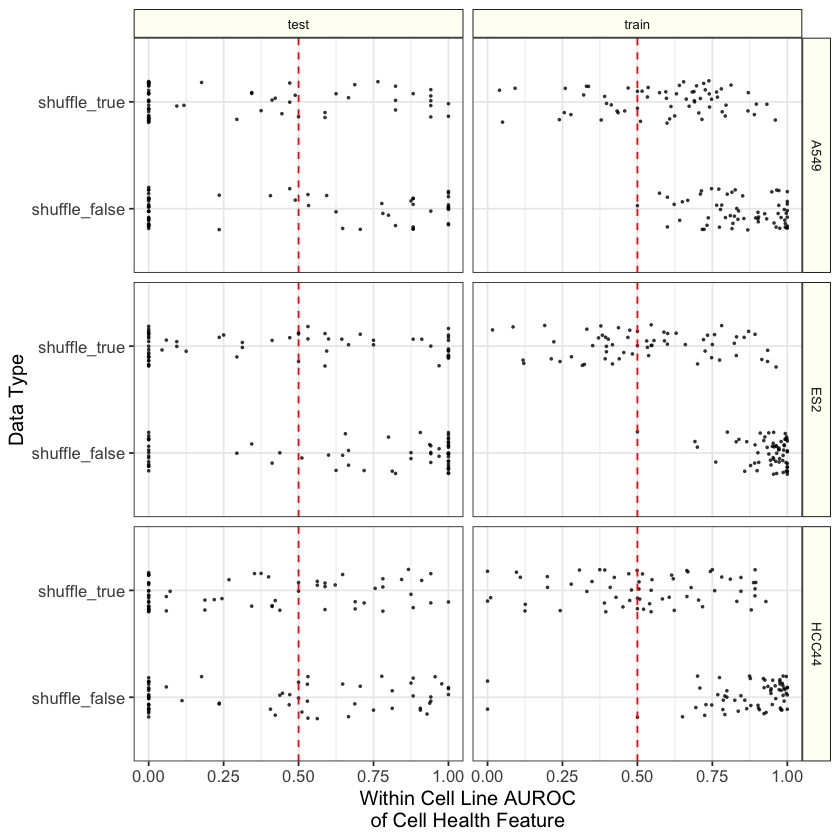

In [22]:
ggplot(auc_df %>% dplyr::filter(metric == "roc"),
       aes(x = shuffle,
           y = auc)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_grid(cell_line~data_fit) +
    xlab("Data Type") +
    ylab("Within Cell Line AUROC\nof Cell Health Feature") +
    coord_flip() +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_roc_differences_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 5, dpi = 500)

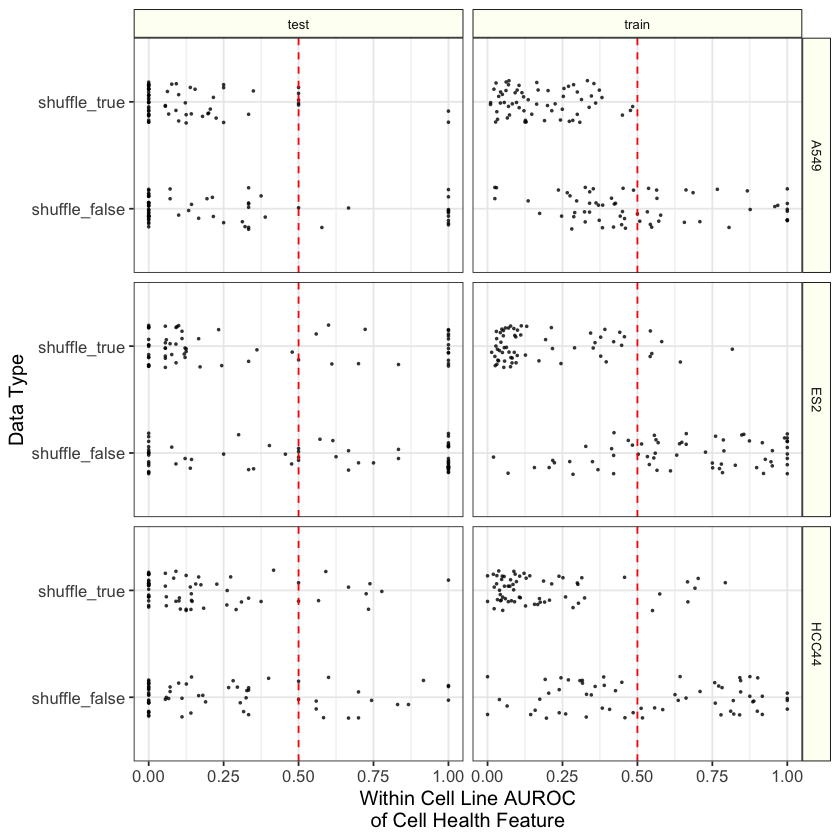

In [23]:
ggplot(auc_df %>% dplyr::filter(metric == "aupr"),
       aes(x = shuffle,
           y = auc)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_grid(cell_line~data_fit) +
    xlab("Data Type") +
    ylab("Within Cell Line AUROC\nof Cell Health Feature") +
    coord_flip() +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_pr_differences_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 5, dpi = 500)

In [24]:
# Compile Results
classification_results_df <- auc_df %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::mutate(plot_group = paste(metric, target, shuffle))

dim(classification_results_df)
head(classification_results_df, 2)

[1] 1512   24

metric,target,auc,cell_line,data_fit,shuffle,y_transform,min_class_count,readable_name,original_name,⋯,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,plot_group
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
roc,cc_all_high_h2ax,0.40917603,HCC44,train,shuffle_true,binarize,29,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,⋯,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,roc cc_all_high_h2ax shuffle_true
roc,cc_all_high_h2ax,0.07142857,HCC44,test,shuffle_true,binarize,29,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,⋯,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,roc cc_all_high_h2ax shuffle_true


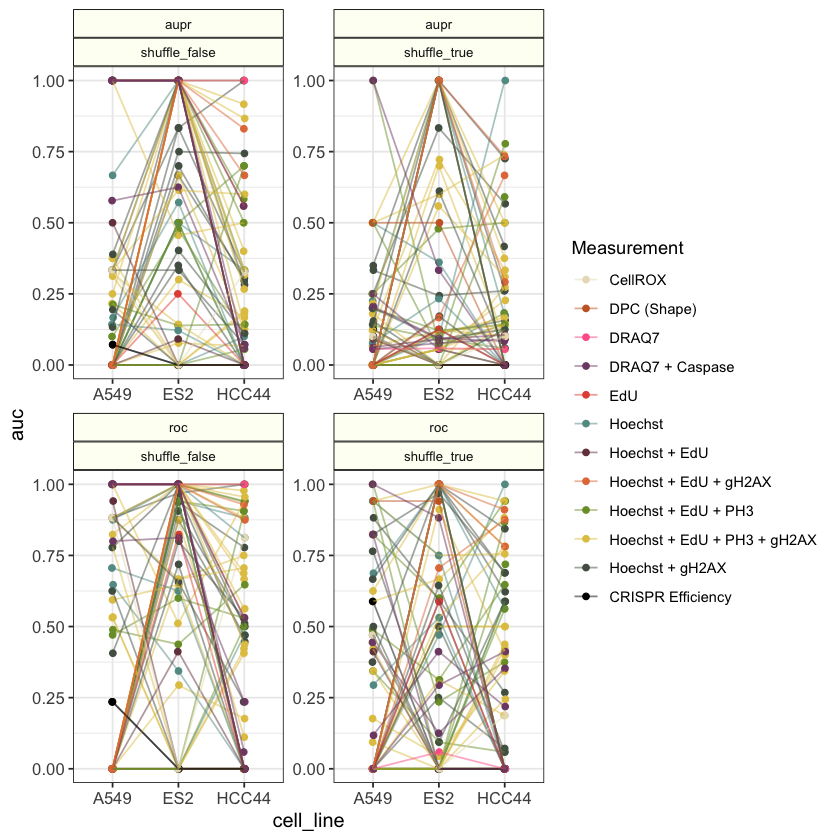

In [25]:
ggplot(classification_results_df %>%
           dplyr::filter(data_fit == "test"),
       aes(x = cell_line,
           y = auc,
           group = plot_group)) +
    geom_jitter(aes(color = assay), width = 0.01) +
    geom_line(aes(color = assay),
              alpha = 0.5) +
    scale_color_manual(name = "Measurement",
                       values = dye_colors,
                       labels = dye_labels) +
    facet_wrap(metric~shuffle, scales = "free") +
    theme_bw() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_differences_classification_target_linked_full_", consensus, ".png")
)
ggsave(output_file, height = 5, width = 6.5, dpi = 500)

## Rank Models based on A549 Performance

In [26]:
spread_classification_results_df <- classification_results_df %>%
    dplyr::filter(
        cell_line == "A549",
        data_fit == "test",
        metric == "aupr"
    ) %>%
    dplyr::select(
        auc, metric, shuffle, target, original_name, readable_name,
        feature_type, measurement, assay, description
    ) %>%
    tidyr::spread(shuffle, auc) %>%
    dplyr::arrange(desc(shuffle_false))

spread_classification_results_df$target <- factor(
    spread_classification_results_df$target,
    levels = rev(unique(spread_classification_results_df$target))
)
spread_classification_results_df$original_name <- factor(
    spread_classification_results_df$original_name,
    levels = rev(unique(spread_classification_results_df$original_name))
)

In [27]:
# Output ranked models
output_file <- file.path(
    "..",
    "4.apply",
    "repurposing_cellhealth_shiny",
    "data",
    paste0("A549_ranked_models_classification_", consensus, ".tsv")
)
readr::write_tsv(spread_classification_results_df, output_file)

print(dim(spread_classification_results_df))
head(spread_classification_results_df, 10)

[1] 63 10


metric,target,original_name,readable_name,feature_type,measurement,assay,description,shuffle_false,shuffle_true
<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
aupr,cc_cc_early_mitosis,CC - G2+pH3 (Early mitiosis) - Mean per Well,CC - % early M,cell_cycle,early_mitosis,hoechst_edu_ph3,Fraction of G2/M cells (Hoechst + EdU),1,0.50000000
aupr,cc_cc_g1,CC - G1 - Mean per Well,CC - % G1,cell_cycle,g1_phase,hoechst_edu_ph3,Fraction of G1 cells,1,1.00000000
aupr,cc_early_mitosis_n_spots_h2ax_mean,G2+pH3 (Early mitiosis) - Number of Spots - Mean per Well,early M - # of gH2AX Spots,cell_cycle,dna_damage,hoechst_edu_ph3_gh2ax,In early M cells: average number of gH2Ax spots,1,0.12500000
aupr,cc_g1_plus_g2_count,G1+G2,Cell Count - G1+G2,cell_cycle,cell_cycle_count,hoechst_edu_ph3,G1+G2,1,0.13888889
aupr,vb_live_cell_area,Live Cell Area [um2],Live Cell Area,viability,shape,dpc,Cell Size,1,0.50000000
aupr,vb_percent_all_apoptosis,% All Apoptosis,% All Apoptosis (CASP+),viability,apoptosis,draq_caspase,% Early Apop + % Late Apop + % Dead Only,1,0.25000000
aupr,vb_percent_dead,% Dead,% All Dead (DRAQ7+),viability,death,draq,Fraction of DRAQ7 positive cells,1,0.05555556
aupr,vb_percent_dead_only,% Dead Only,% Dead Only (CASP-; DRAQ7+),viability,apoptosis,draq_caspase,Fraction of caspase negative in dead cells,1,0.06250000
aupr,vb_percent_early_apoptosis,% Early Apop,% Early Apoptosis (CASP+; DRAQ7-),viability,apoptosis,draq_caspase,Fraction of caspase positive in live cells (no DRAQ7),1,1.00000000


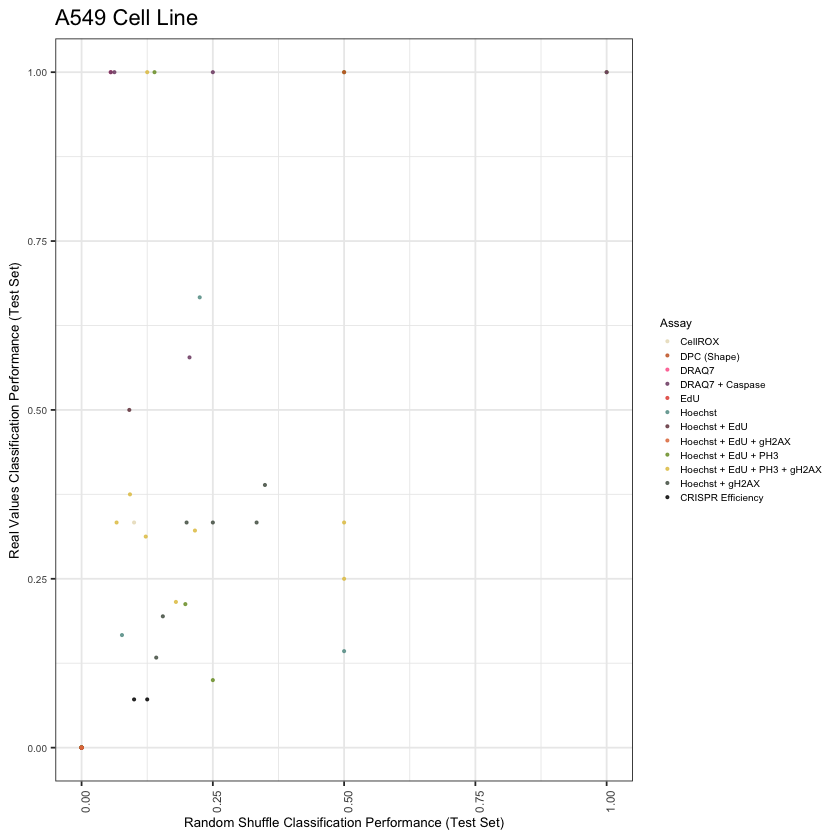

In [28]:
ggplot(spread_classification_results_df, aes(x = shuffle_true, y = shuffle_false)) +
    geom_point(aes(color = assay),
               size = 0.5,
               alpha = 0.8) +
    xlab("Random Shuffle Classification Performance (Test Set)") +
    ylab("Real Values Classification Performance (Test Set)") +
    ggtitle("A549 Cell Line") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 6),
          axis.text.x = element_text(size = 7, angle = 90),
          axis.title = element_text(size = 8),
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 6),
          legend.key.size = unit(0.3, "cm")) +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) 

output_file = file.path(
    figure_dir,
    paste0("ranked_models_A549_with_shuffle_classification_", consensus, ".png")
)
ggsave(output_file, dpi = 300, height = 3.5, width = 4)

In [29]:
classification_rank_plot_df <- build_plot_data(
    classification_results_df, cell_line="A549", data_fit="test", metric="aupr", results_type="classification"
)

sorted_non_shuffle <- classification_rank_plot_df %>%
    dplyr::filter(shuffle == "shuffle_false") %>%
    dplyr::arrange(desc(auc))

target_levels <- rev(
    sorted_non_shuffle %>%
        dplyr::pull(target)
    )

name_levels <- rev(
    sorted_non_shuffle %>%
        dplyr::pull(readable_name)
    )

classification_rank_plot_df$target <- factor(
    classification_rank_plot_df$target, levels = target_levels
)
classification_rank_plot_df$readable_name <- factor(
    classification_rank_plot_df$readable_name,
    levels = name_levels
)

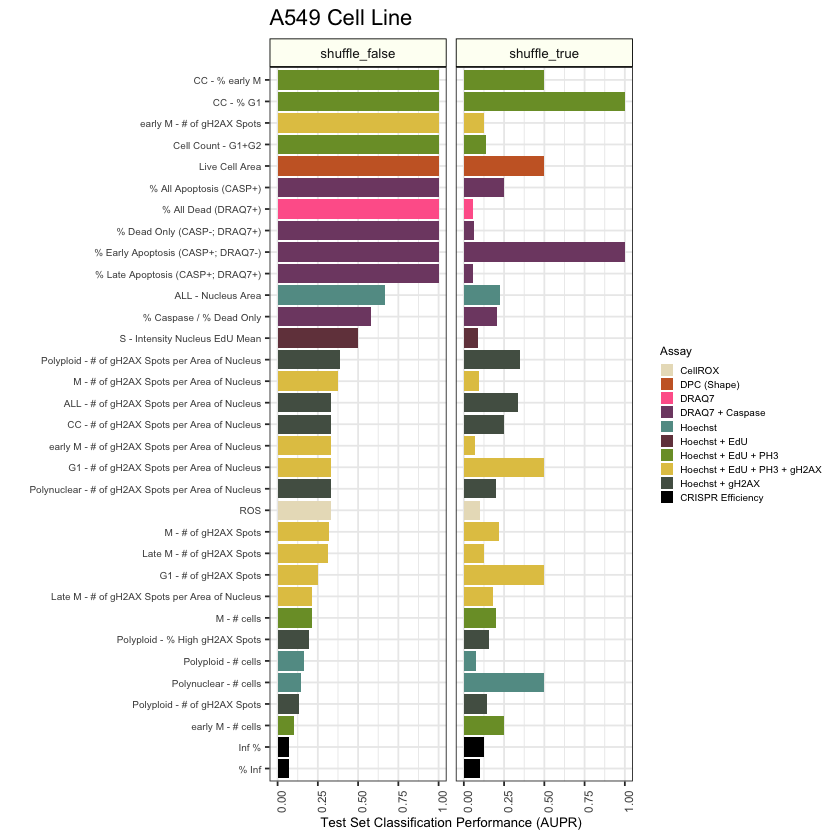

In [30]:
ggplot(classification_rank_plot_df %>% dplyr::filter(auc > 0),
       aes(x = readable_name, y = auc)) +
    geom_bar(aes(fill = assay), stat="identity") +
    ylab("Test Set Classification Performance (AUPR)") +
    xlab("") +
    ggtitle("A549 Cell Line") +
    coord_flip() +
    ylim(c(0, 1)) +
    facet_wrap(~shuffle, nrow = 1) +
    theme_bw() +
    theme(
        axis.text.y = element_text(size = 6),
        axis.text.x = element_text(size = 7, angle = 90),
        axis.title = element_text(size = 8),
        legend.title = element_text(size = 7),
        legend.text = element_text(size = 6),
        legend.key.size = unit(0.3, "cm"),
        strip.text = element_text(size = 8),
        strip.background = element_rect(colour = "black",
                                        fill = "#fdfff4")
    ) +
    scale_fill_manual(
        name = "Assay",
        values = dye_colors,
        labels = dye_labels
    )

output_file = file.path(
    figure_dir,
    paste0("ranked_models_A549_", consensus, "_classification.png")
)
ggsave(output_file, dpi = 300, height = 6, width = 8)